In [474]:
import os
import imageio
import matplotlib.pyplot as plt
import cv2
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy
from amftrack.pipeline.functions.image_processing.node_id import remove_spurs
from amftrack.pipeline.functions.image_processing.extract_skel import remove_component, remove_holes
import numpy as np
from amftrack.pipeline.development.high_mag_videos.high_mag_videos_fun import *
from scipy import signal
from amftrack.pipeline.functions.image_processing.extract_skel import (
    extract_skel_new_prince,
    run_back_sub,
    bowler_hat,
)
from scipy.interpolate import griddata

from skimage.morphology import skeletonize
from amftrack.util.sys import temp_path
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit

plt.style.use('presentation.mplstyle')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [557]:
images_path = r"/mnt/sun/home-folder/Jaap/Transport setup 4 x NileRed/All frames"
images_path = r"/mnt/sun/home-folder/cargill/20221027_plate452/20221027_plate452_019"
# images_path = r"/mnt/sun/home-folder/cargill/20221109_Plate462/20221109_Plate462_006"
fps = 20
time_pixel_size = 1/fps #s.pixel
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel
video_name = images_path.split('/')[-1]
kymos_path = '/'.join(images_path.split('/')[:-1]+["_".join((video_name,'kymos'))])
if not os.path.exists(kymos_path):
    os.mkdir(kymos_path)
files = os.listdir(images_path)
images_total_path = [os.path.join(images_path,file) for file in files]
images_total_path.sort()


/data/temp/ipykernel_1267872/3807674148.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(selection_file[end])
/data/temp/ipykernel_1267872/3807674148.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread(selection_file[begin])
/data/temp/ipykernel_1267872/3807674148.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


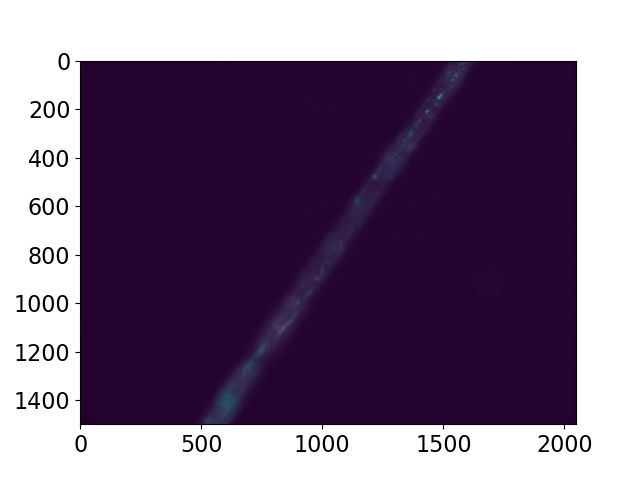

In [560]:
selection_file = images_total_path
selection_file.sort()
begin  = 300
end = -1
image = imageio.imread(selection_file[end])
image2 = imageio.imread(selection_file[begin])
selection_file = selection_file[begin:end]

fig, ax = plt.subplots()
ax.imshow(image,cmap="gray")
ax.imshow(image2,alpha = 0.5)


In [561]:
images = [imageio.imread(file) for file in selection_file[::10]]
images = [cv2.resize(image, np.flip(images[0].shape)) for image in images]

/data/temp/ipykernel_1267872/2307635982.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(file) for file in selection_file[::10]]


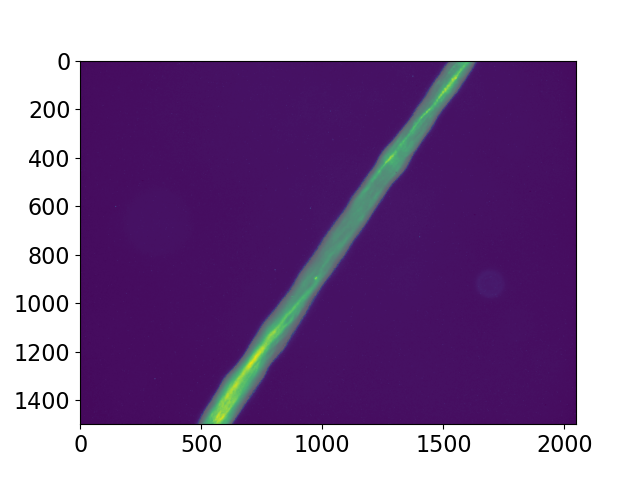

In [592]:
fig, ax = plt.subplots()
mean_proj = np.mean(np.array(images), axis=0)
smooth_im = cv2.blur(mean_proj,(3,3))

thresh = 10
ax.imshow(smooth_im)

ax.imshow(mean_proj>thresh,alpha = 0.2)


In [598]:
def remove_holes(hyst,itera = 5):
    kernel = np.ones((3, 3), np.uint8)
    dilation = cv2.dilate(hyst.astype(np.uint8) * 255, kernel, iterations=itera)
    for i in range(3):
        dilation = cv2.erode(dilation.astype(np.uint8) * 255, kernel, iterations=itera)
        dilation = cv2.dilate(dilation.astype(np.uint8) * 255, kernel, iterations=itera)
    return dilation > 0

In [601]:

segmented = mean_proj>thresh
segmented = remove_holes(segmented)
connected = remove_component(segmented)>0
skeletonized = skeletonize(connected)
skeleton = scipy.sparse.dok_matrix(skeletonized)
nx_graph, pos = generate_nx_graph(from_sparse_to_graph(skeleton))
nx_graph_pruned, pos = remove_spurs(nx_graph, pos, threshold=100)

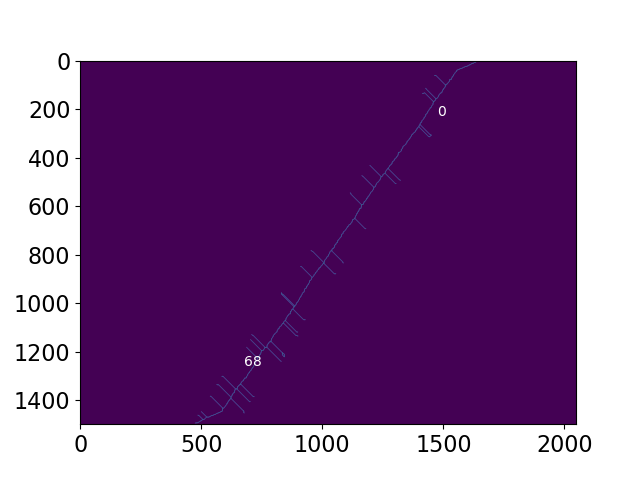

In [602]:
fig, ax = plt.subplots()
ax.imshow(skeletonized)
weight = 0.15
for edge in list(nx_graph_pruned.edges):
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")

In [603]:
edge = 68,0

In [604]:
edges = [edge]
# edges = [(958,668),(668,24),(668,527)]

In [493]:
edges

[(1, 265)]

In [454]:
def gauss(x, H, A, x0, sigma):
    return(H + A*np.exp(-(x-x0)**2/(2*sigma**2)))

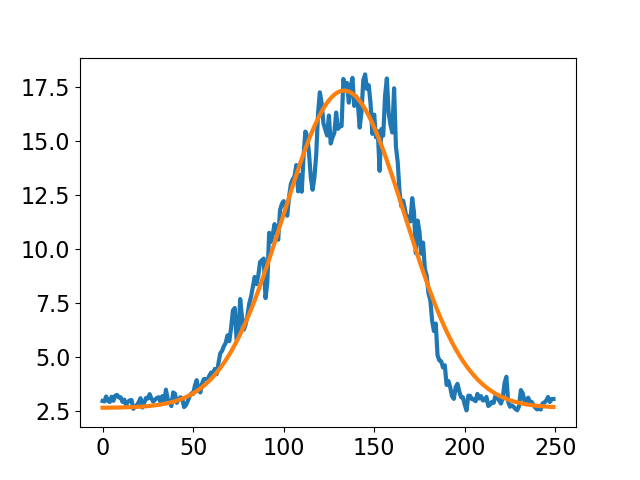

In [472]:

weight = 0.05
bound1 = 0
bound2 = 1
offset=200
step=30
target_length=250
resolution = 1
widths = {}
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    std_proj,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    sigmas = []
    for slice_obj in slices[::25]:
        try:
            popt, pcov = curve_fit(gauss, np.array(range(len(slice_obj))),
                                   slice_obj,p0 = [0,125,target_length/2,10],
                                   bounds = ([-np.inf,0,0,0],[np.inf,np.inf,np.inf,np.inf]))
            sigmas.append(popt[3])
            fig, ax = plt.subplots()
            x = np.array(range(len(slice_obj)))
            ax.plot(slice_obj)
            ax.plot(x,gauss(x,*popt))
        except:
            pass
        break
    widths[edge] = 2*np.median(sigmas)*space_pixel_size


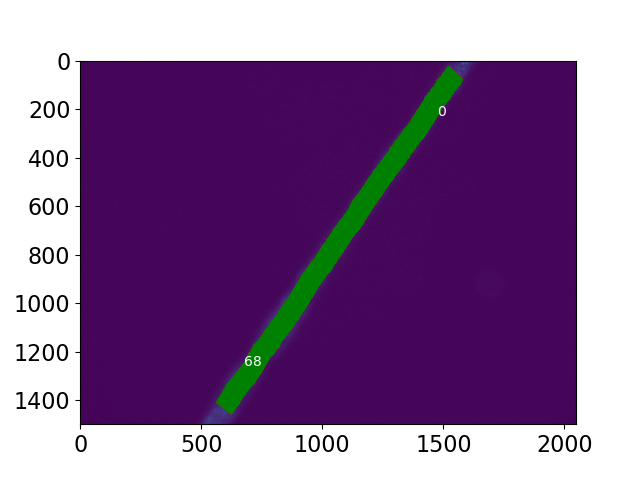

In [605]:
plt.close("all")
fig, ax = plt.subplots()
ax.imshow(image)
bound1 = 0
bound2 = 1
offset=100
step=30
target_length=70
resolution = 1
for edge in edges:
    slices, segments = extract_section_profiles_for_edge(
    edge,
    pos,
    image,
    nx_graph_pruned,
    resolution=resolution,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2
)
    plot_segments_on_image(segments,ax)
    plot_segments_on_image(segments,ax,color="green", bound1=bound1,
    bound2=bound2)
    ax.text(*np.flip((1-weight) * pos[edge[0]]+weight*pos[edge[1]]),str(edge[0]),color="white")
    ax.text(*np.flip((1-weight) * pos[edge[1]]+weight*pos[edge[0]]),str(edge[1]),color="white")
save_path_temp = os.path.join(kymos_path, f"extraction.png")
plt.savefig(save_path_temp)

In [606]:
kymos = {edge:get_kymo(edge,pos,selection_file,nx_graph_pruned, resolution=1,
    offset=offset,
    step=step,
    target_length=target_length,
    bound1=bound1,
    bound2=bound2) for edge in edges}

In [534]:
kymos

{(1837,
  1417): array([[29.67142857, 28.14285714, 27.27142857, ..., 54.67142857,
         55.92857143, 56.38571429],
        [28.04285714, 28.22857143, 28.12857143, ..., 56.2       ,
         55.88571429, 56.2       ],
        [29.41428571, 29.95714286, 28.27142857, ..., 58.9       ,
         59.17142857, 55.3       ],
        ...,
        [44.15714286, 46.44285714, 53.01428571, ..., 53.88571429,
         53.14285714, 52.28571429],
        [48.34285714, 53.7       , 54.71428571, ..., 52.82857143,
         52.35714286, 53.22857143],
        [50.94285714, 54.14285714, 55.85714286, ..., 53.38571429,
         52.7       , 53.07142857]])}

In [607]:
for edge in kymos.keys():
    kymo = kymos[edge]
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.npy")
    np.save(save_path_temp,kymo)
    im = Image.fromarray(kymo.astype(np.uint8))
    save_path_temp = os.path.join(kymos_path, f"{edge}kymo.png")
    im.save(save_path_temp)

In [608]:
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}

In [609]:
for edge in kymos.keys():
    for i in [0,1]:
        kymo = filtered_kymos[edge][i]
        suffix = 'right' if i==0 else "left"
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.npy")
        np.save(save_path_temp,kymo)
        im = Image.fromarray(((kymo-np.min(kymo))/np.max(kymo)*128).astype(np.uint8))
        save_path_temp = os.path.join(kymos_path, f"{edge}kymo_{suffix}.png")
        im.save(save_path_temp)

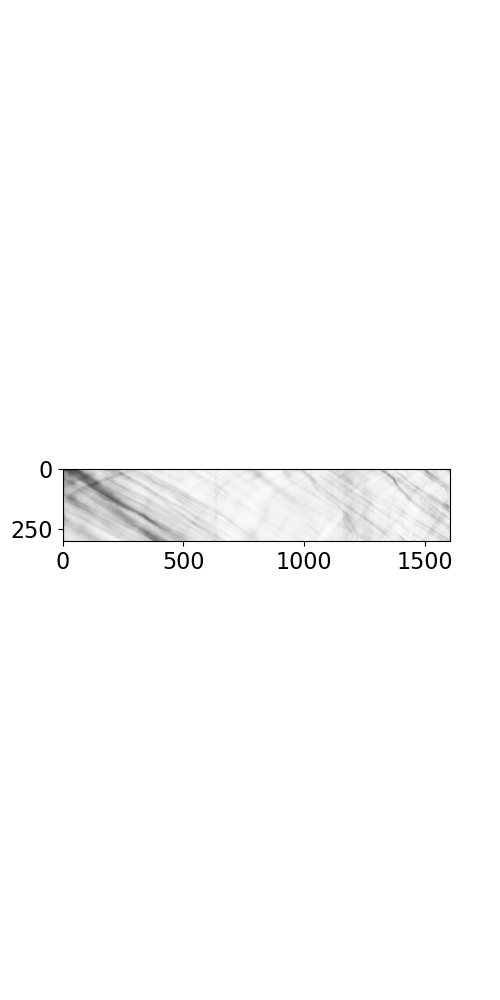

In [610]:
fig,ax = plt.subplots(figsize = (5,10))
ax.imshow(kymos[edge],cmap='Greys')

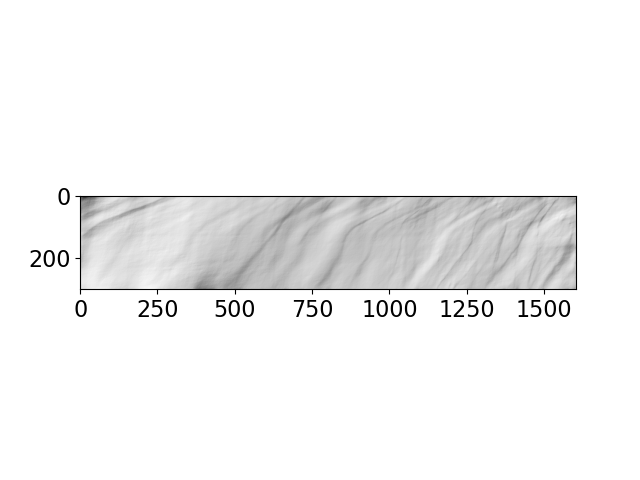

In [611]:
fig,ax = plt.subplots()
ax.imshow(filter_kymo(kymos[edge])[0],cmap='Greys')

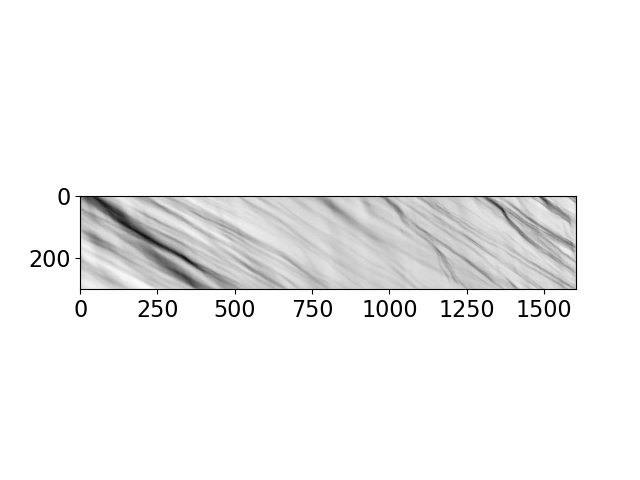

In [612]:
fig,ax = plt.subplots()
ax.imshow(filter_kymo(kymos[edge])[1],cmap='Greys')

/data/temp/ipykernel_1267872/3820769486.py:31: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
/home/ipausers/bisot/miniconda3/envs/amftrack/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/data/temp/ipykernel_1267872/3820769486.py:31: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
/home/ipausers/bisot/miniconda3/envs/amftrack/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=o

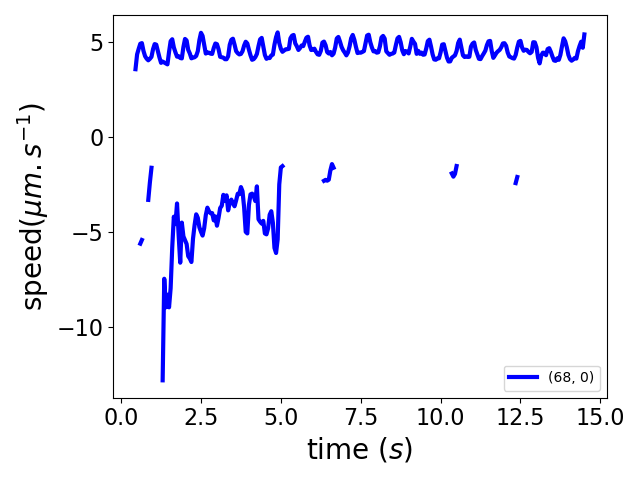

In [613]:
fig, ax = plt.subplots()
colors = ['blue','red','yellow','green']
speed_dataframe = pd.DataFrame()
for j,edge in enumerate(edges):
    color = colors[j]
    for i in [0,1]:
        kymo = filter_kymo(kymos[edge])[i]
        W = int(5/space_pixel_size)          # window size is WxW
        W = 3
        C_Thr = 0.95
        imgCoherency, imgOrientation = calcGST(kymo, W)
        nans = np.empty(imgOrientation.shape)
        nans.fill(np.nan)
        real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
        speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed<20,speed,nans)
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(speed>-20,speed,nans)
        # # ax.imshow((imgCoherency))
        klen = 25
        kernel = np.ones((klen,klen))/klen**2
        z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
        nans = np.empty(speed.shape)
        nans.fill(np.nan)
        speed = np.where(z1>0.8,speed,nans)
        label =edge if i==0 else None
        times = np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size
        speeds = np.nanmean(speed,axis=1)
        edges_list = [edge for k in range(len(speeds))]
        direction = ["root" if i==0 else 'tip' for k in range(len(speeds))]
        data = pd.DataFrame(np.transpose((times,speeds,edges_list,direction)),
                     columns = ['time (s)','speed (um.s-1)','edge','direction'])
        speed_dataframe = pd.concat((speed_dataframe,data))
        ax.plot(times,speeds,label =edge if i==0 else None,color = color)
        ax.set_ylabel('speed($\mu m.s^{-1}$)')
        ax.set_xlabel('time ($s$)')
save_path_temp = os.path.join(kymos_path, f"speed_data.csv")
speed_dataframe.to_csv(save_path_temp)
plt.legend()
plt.tight_layout()

/data/temp/ipykernel_1267872/1437984998.py:30: RuntimeWarning: Mean of empty slice
  speeds = np.nanmean(speed,axis=1)
/home/ipausers/bisot/miniconda3/envs/amftrack/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


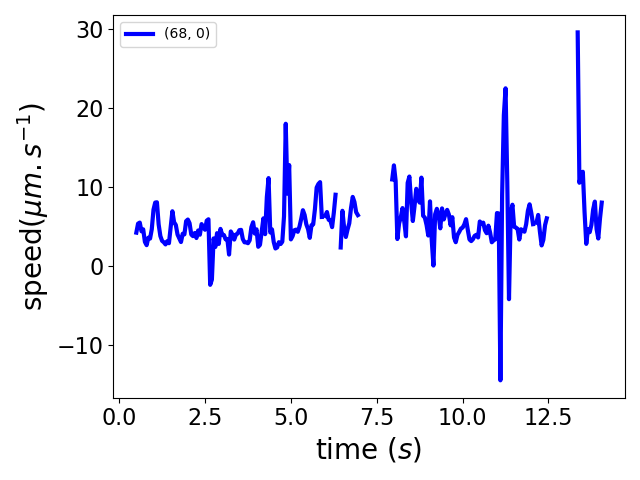

In [614]:
fig, ax = plt.subplots()
colors = ['blue','red','yellow','green','pink','orange','black','purple','brown','cyan','magenta']
speed_dataframe = pd.DataFrame()
for j,edge in enumerate(kymos.keys()):
    color = colors[j]
    kymo = kymos[edge]
    W = int(5/space_pixel_size)          # window size is WxW
    W = 3
    C_Thr = 0.95
    imgCoherency, imgOrientation = calcGST(kymo, W)
    nans = np.empty(imgOrientation.shape)
    nans.fill(np.nan)
    real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
    speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed<150,speed,nans)
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed>-150,speed,nans)
    # # ax.imshow((imgCoherency))
    klen = 25
    kernel = np.ones((klen,klen))/klen**2
    z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(z1>0.8,speed,nans)
    label =edge if i==0 else None
    times = np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size
    speeds = np.nanmean(speed,axis=1)
    edges_list = [edge for k in range(len(speeds))]
    data = pd.DataFrame(np.transpose((times,speeds,edges_list)),
                 columns = ['time (s)','speed (um.s-1)','edge'])
    speed_dataframe = pd.concat((speed_dataframe,data))
    ax.plot(times,speeds,label = edge,color = color)
    ax.set_ylabel('speed($\mu m.s^{-1}$)')
    ax.set_xlabel('time ($s$)')
save_path_temp = os.path.join(kymos_path, f"speed_data_no_direction.csv")
speed_dataframe.to_csv(save_path_temp)
plt.legend()
plt.tight_layout()
plt.legend()
plt.tight_layout()

/data/temp/ipykernel_1267872/4176184974.py:70: RuntimeWarning: Mean of empty slice
  ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))


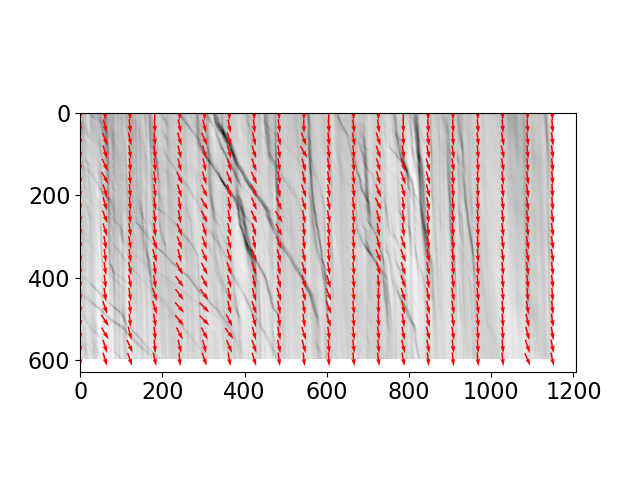

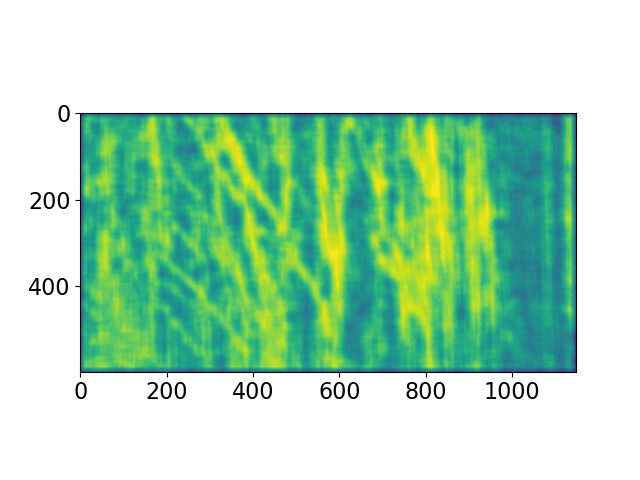

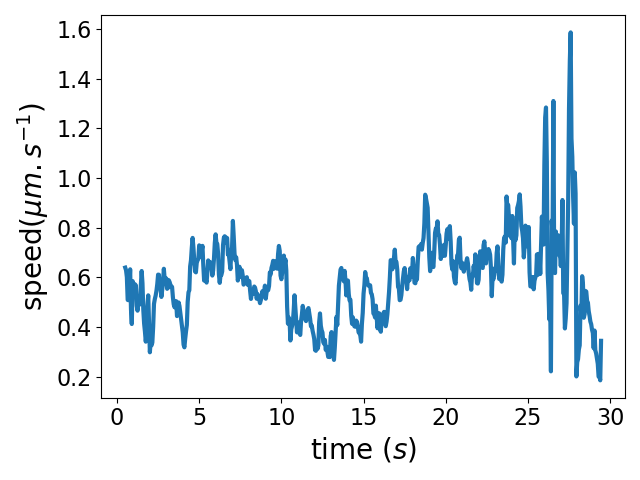

In [302]:
fig, ax = plt.subplots()
kymo = filter_kymo(kymos[edge])[1]
ax.imshow(kymo,cmap="Greys")
fps = 20
time_pixel_size = 1/fps #s.pixel
binning = 2
magnification = 50
space_pixel_size = 2*1.725/(magnification)*binning #um.pixel

W = 5
C_Thr = 0.95
imgCoherency, imgOrientation = calcGST(kymo, W)
nans = np.empty(imgOrientation.shape)
nans.fill(np.nan)

real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1

a= speed
x, y = np.indices(a.shape)
interp = a
interp[np.isnan(interp)] = griddata(
    (x[~np.isnan(a)], y[~np.isnan(a)]), # points we know
    a[~np.isnan(a)],                    # values we know
    (x[np.isnan(a)], y[np.isnan(a)]))   # points to interpolate
a= speed
x, y = np.indices(a.shape)
interp = a
interp[np.isnan(interp)] = griddata(
    (x[~np.isnan(a)], y[~np.isnan(a)]), # points we know
    a[~np.isnan(a)],                    # values we know
    (x[np.isnan(a)], y[np.isnan(a)]),method='nearest')   # points to interpolate
klen = 50
kernel = np.ones((klen,klen))/klen**2


z1 = scipy.signal.convolve2d(interp, kernel)
grid_size = 20
x,y = np.meshgrid(np.linspace(0,kymo.shape[1],grid_size),np.linspace(0,kymo.shape[0],grid_size))
shape  = speed.shape
speed_reduced = z1[::shape[0]//grid_size,::shape[1]//grid_size]
speed_reduced = 1/(speed_reduced/(space_pixel_size/time_pixel_size))
norm = 0.5
v = -norm * speed_reduced/(np.sqrt(1+speed_reduced**2))
u = norm/(np.sqrt(1+speed_reduced**2))
u = u[:grid_size,:grid_size]
v = v[:grid_size,:grid_size]
ax.quiver(x,y,u,v,pivot = "mid",color="red")

fig, ax = plt.subplots()

ax.imshow(imgCoherency)
speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1

nans = np.empty(speed.shape)
nans.fill(np.nan)
speed = np.where(speed<150,speed,nans)
nans = np.empty(speed.shape)
nans.fill(np.nan)
speed = np.where(speed>-150,speed,nans)
klen = 25
kernel = np.ones((klen,klen))/klen**2
z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
ax.imshow(z1)
nans = np.empty(speed.shape)
nans.fill(np.nan)
speed = np.where(z1>0.80,speed,nans)

fig, ax = plt.subplots()
ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))
ax.set_ylabel('speed($\mu m.s^{-1}$)')
ax.set_xlabel('time ($s$)')
plt.tight_layout()

/data/temp/ipykernel_1267872/298920657.py:33: RuntimeWarning: Mean of empty slice
  ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))
/data/temp/ipykernel_1267872/298920657.py:33: RuntimeWarning: Mean of empty slice
  ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))


(-3.0, 6.5)

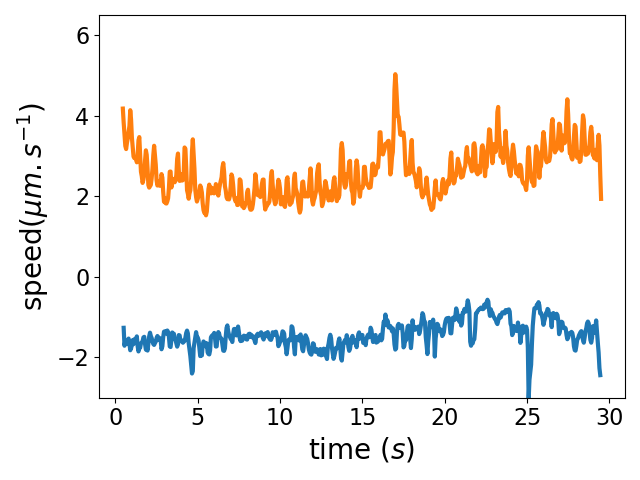

In [160]:
fig, ax = plt.subplots()

for i in [0,1]:   
    kymo = filter_kymo(kymos[edge])[i]


    fps = 20
    time_pixel_size = 1/fps #s.pixel
    binning = 2
    magnification = 50
    space_pixel_size = 2*1.725/(magnification)*binning #um.pixel
    W = int(5/space_pixel_size)          # window size is WxW
    W = 3
    C_Thr = 0.95
    imgCoherency, imgOrientation = calcGST(kymo, W)
    nans = np.empty(imgOrientation.shape)
    nans.fill(np.nan)
    real_movement = np.where(imgCoherency>C_Thr,imgOrientation,nans)
    speed=np.tan((real_movement-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed<20,speed,nans)
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(speed>-20,speed,nans)
    # # ax.imshow((imgCoherency))
    klen = 25
    kernel = np.ones((klen,klen))/klen**2
    z1 = scipy.signal.convolve2d(imgCoherency, kernel,mode = "same")
    nans = np.empty(speed.shape)
    nans.fill(np.nan)
    speed = np.where(z1>0.8,speed,nans)
    ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))
    ax.set_ylabel('speed($\mu m.s^{-1}$)')
    ax.set_xlabel('time ($s$)')
plt.tight_layout()
ax.set_ylim(-3,6.5)

In [71]:
speed_dataframe

time (s) speed (um.s-1)         edge direction
0        0.0            NaN  (3376, 670)      root
1       0.05            NaN  (3376, 670)      root
2        0.1            NaN  (3376, 670)      root
3       0.15            NaN  (3376, 670)      root
4        0.2            NaN  (3376, 670)      root
..       ...            ...          ...       ...
596     29.8            NaN   (670, 468)       tip
597    29.85            NaN   (670, 468)       tip
598     29.9            NaN   (670, 468)       tip
599    29.95            NaN   (670, 468)       tip
600     30.0            NaN   (670, 468)       tip

[2404 rows x 4 columns]

In [48]:
import scipy as sp

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [283]:
signal_ZMUV

array([ 1.86639204e+00,  5.52278186e-01, -3.07376195e-01, -9.69857105e-01,
       -1.06276927e+00, -1.07333051e+00, -9.45002808e-01,  2.87258719e-01,
        1.33741307e+00,  1.29276114e+00,  3.71235647e-01, -4.66837932e-01,
       -6.66593923e-01, -9.00114417e-01, -1.05425261e+00, -7.11386628e-01,
        5.99428447e-01,  1.60356417e+00,  1.73271432e+00,  7.34991587e-01,
       -3.72915173e-01, -6.68713910e-01, -4.61410104e-01, -5.68999810e-01,
       -8.30656594e-01, -5.62088542e-01,  7.27716743e-01,  1.41524375e+00,
        1.43622884e+00,  4.46656463e-01, -5.94992675e-01, -9.96278645e-01,
       -7.90092982e-01, -6.58321182e-01, -4.63318502e-01,  4.73360241e-01,
        1.60374568e+00,  1.70171503e+00,  5.97340210e-01, -5.20986350e-01,
       -6.43474467e-01, -4.91283038e-01, -4.16110915e-01, -4.19077348e-01,
       -3.02899471e-01,  6.56845913e-01,  1.44771381e+00,  1.73239073e+00,
        9.07742523e-01, -9.56907905e-02, -6.47379321e-01, -5.12916853e-01,
       -4.80127555e-01,  

/data/temp/ipykernel_1267872/712410310.py:1: RuntimeWarning: Mean of empty slice
  signal = np.nanmean(speed,axis=1)[10:]


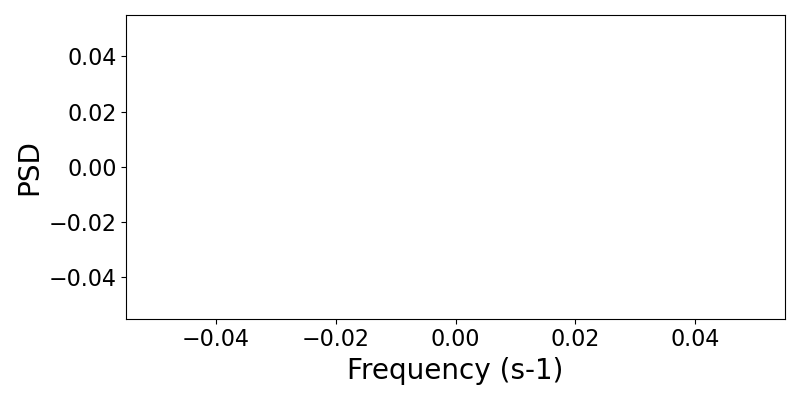

In [49]:
signal = np.nanmean(speed,axis=1)[10:]
frequ = 1/time_pixel_size
signal_ZMUV = (signal-np.nanmean(signal))/np.nanstd(signal)
s = signal_ZMUV
autoc = autocorr(s)
autoc = autoc/autoc.max()
speed_fft = np.fft.fft(s)
speed_psd = np.abs(speed_fft) ** 2
fftfreq = np.fft.fftfreq(len(speed_psd))
i = fftfreq > 0
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(frequ*fftfreq[i], speed_psd[i])
ax.set_xlabel('Frequency (s-1)')
ax.set_ylabel('PSD')
plt.tight_layout()

In [82]:
grid_size = 10

speed[::grid_size,::grid_size]

array([[ 4.59676577e-01,  7.66176542e-02, -2.19914605e-03, ...,
         3.70815816e-01,  1.82842855e+00,  3.28604128e+00],
       [ 1.34949234e+00,  1.50626766e+00,  2.53012743e+00, ...,
         2.30218255e+00,  2.77255631e+00,  5.06519968e+00],
       [ 3.11491230e+00,  4.71153219e+00,  3.29803017e+00, ...,
         3.16016495e+00,  3.19224957e+00,  8.02133617e+00],
       ...,
       [ 7.08085409e+00,  2.04182902e+00,  2.59842765e+00, ...,
         1.03982026e+01,  1.15257400e+01,  1.46474600e+01],
       [ 3.80897872e+00,  1.28497890e+00,  9.83274595e-01, ...,
         5.88288032e+00,  9.15069289e+00,  1.58762503e+01],
       [ 5.37103355e-01,  5.29397928e-01,  5.13987073e-01, ...,
         3.73989625e+00,  7.54209296e+00,  1.02121182e+01]])

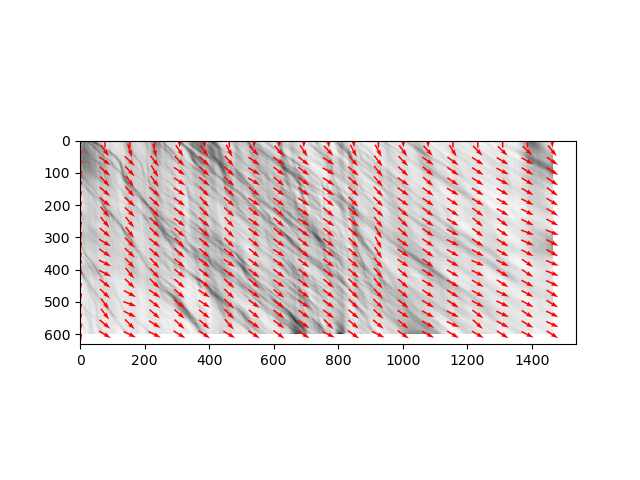

In [149]:
fig, ax = plt.subplots()
kymo = filter_kymo(kymos[edge])[1]
ax.imshow(kymo,cmap="Greys")
grid_size = 20
x,y = np.meshgrid(np.linspace(0,kymo.shape[1],grid_size),np.linspace(0,kymo.shape[0],grid_size))
shape  = speed.shape
speed_reduced = z1[::shape[0]//grid_size,::shape[1]//grid_size]
speed_reduced = 1/(speed_reduced/(space_pixel_size/time_pixel_size))
norm = 0.5
v = -norm * speed_reduced/(np.sqrt(1+speed_reduced**2))
u = norm/(np.sqrt(1+speed_reduced**2))
u = u[:grid_size,:grid_size]
v = v[:grid_size,:grid_size]
ax.quiver(x,y,u,v,pivot = "mid",color="red")


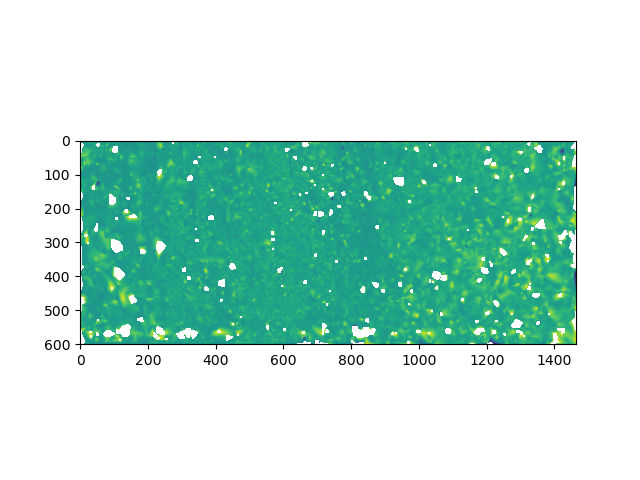

In [154]:
fig, ax = plt.subplots()
ax.imshow(speed)

In [98]:
v.shape

(10, 10)

Text(0.5, 0, 'time ($s$)')

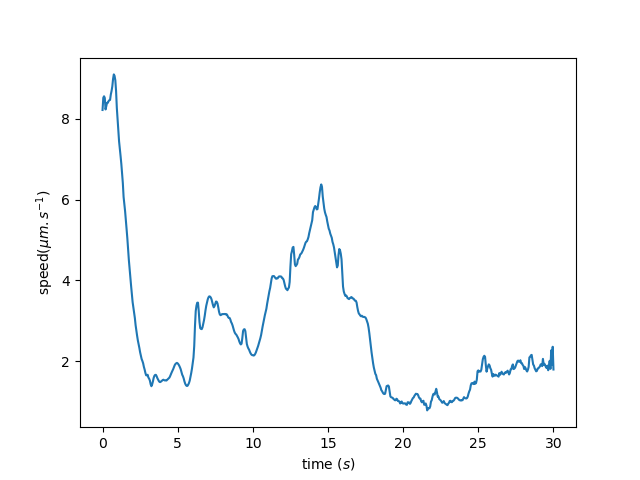

In [147]:
fig, ax = plt.subplots()
ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))
ax.set_ylabel('speed($\mu m.s^{-1}$)')
ax.set_xlabel('time ($s$)')
# ax.set_ylim(-2.1,-0.9)

/data/temp/ipykernel_1055792/828965940.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


(-2.1, -0.9)

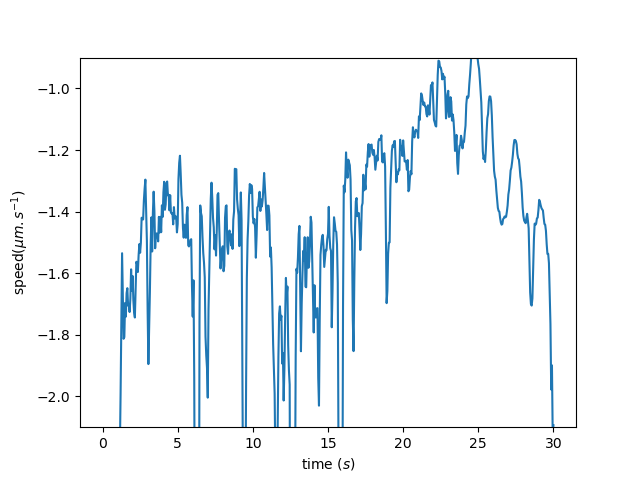

In [149]:
fig, ax = plt.subplots()
ax.plot(np.array(range(len(np.mean(speed,axis=1))))*time_pixel_size,np.nanmean(speed,axis=1))
ax.set_ylabel('speed($\mu m.s^{-1}$)')
ax.set_xlabel('time ($s$)')
ax.set_ylim(-2.1,-0.9)

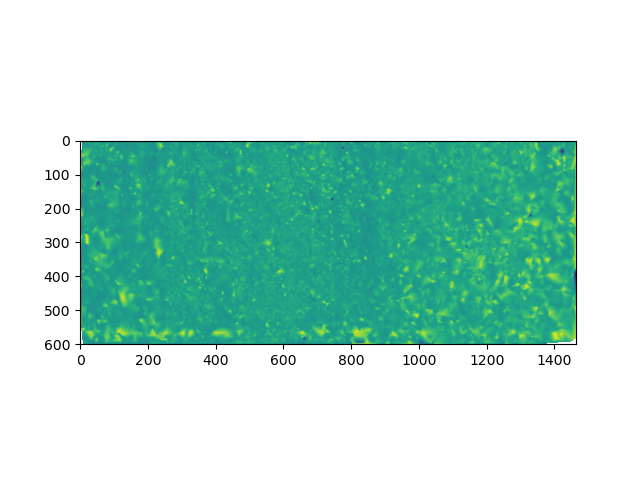

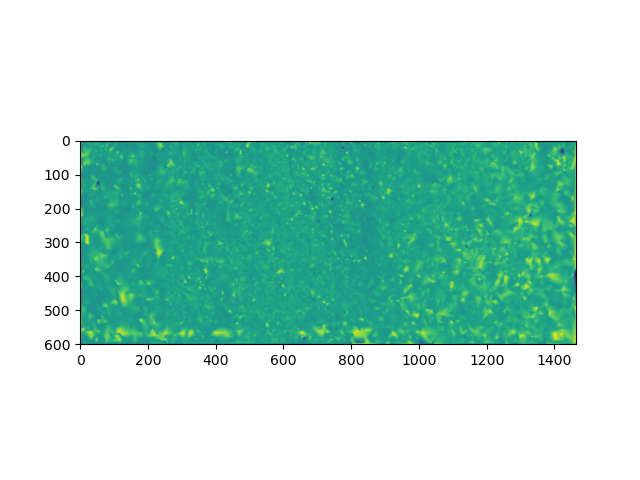

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.mean(speed,axis=1))

In [48]:
filtered_kymos = {edge: filter_kymo(kymos[edge]) for edge in edges}
speeds = {}

In [69]:
W = 50          # window size is WxW
time_pixel_size = 0.10 #s.pixel
space_pixel_size = 1.725/25 #um.pixel
speeds = {}
for edge in edges:
    imgCoherency, imgOrientation = calcGST(kymos[edge], W)
    # imgCoherency, imgOrientation = calcGST(filtered_kymos[edge][1], W)
    
    speeds[edge]=np.tan((imgOrientation-90)/180*np.pi)*space_pixel_size/time_pixel_size #um.s-1
    # speeds[edge]=speeds[edge][:,:300]


In [50]:
corrs = {}
for edge in edges:
    to_treat = (speeds[edge]-np.mean(speeds[edge]))/np.std(speeds[edge])
    corr = signal.correlate2d(to_treat, to_treat)
    corrs[edge]=corr/np.max(corr)

In [51]:
import math
def gridplot(
    n: int,
    ncols = None,
    subw: float = 4.0,
    subh: float = 4.0,
    **kwargs,
):
    if ncols is None:
        ncols = n
    nrows = math.ceil(n / ncols)
    figsize = (subw * ncols, subh * nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    return fig, iter(axs.flatten())

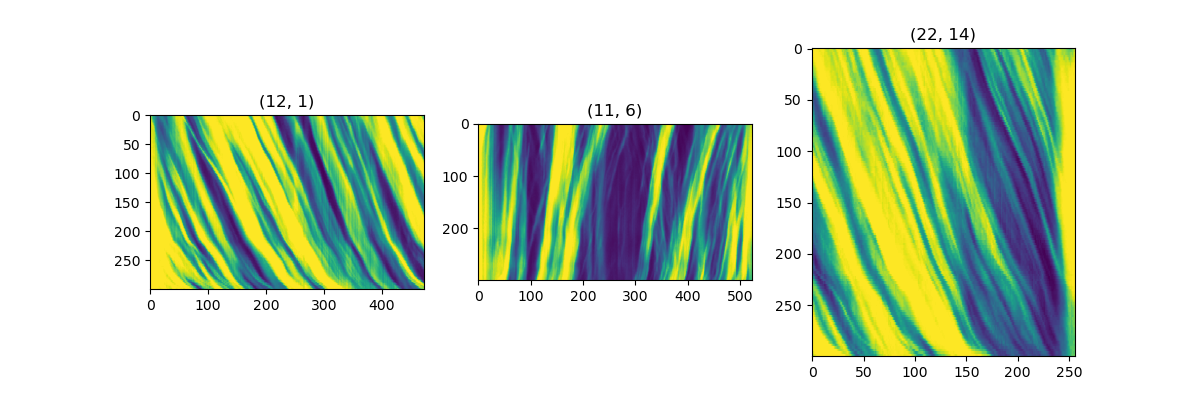

In [52]:
fig,axs = gridplot(len(kymos),ncols = 3)
for i,ax in enumerate(axs):
    ax.imshow(kymos[edges[i]])
    ax.set_title(str(edges[i]))

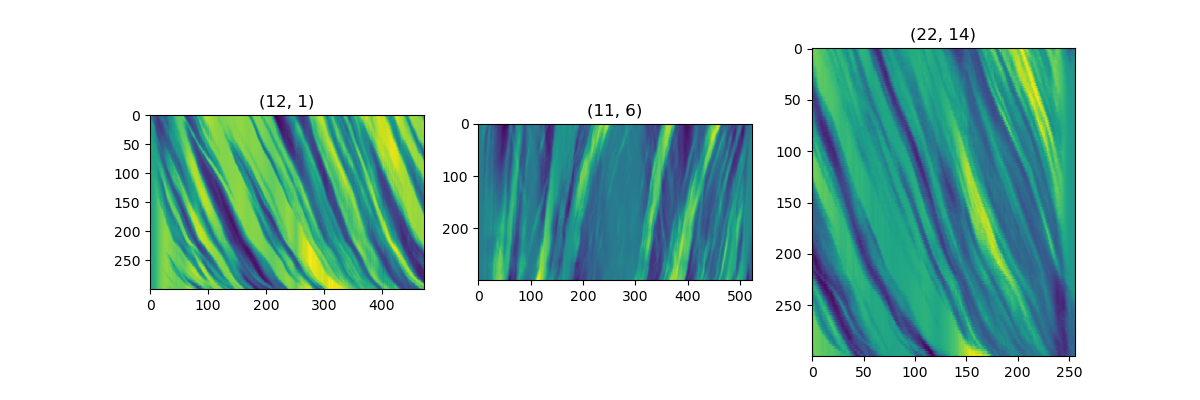

In [57]:
fig,axs = gridplot(len(kymos),ncols = 3)
for i,ax in enumerate(axs):
    ax.imshow(filtered_kymos[edges[i]][1])
    ax.set_title(str(edges[i]))

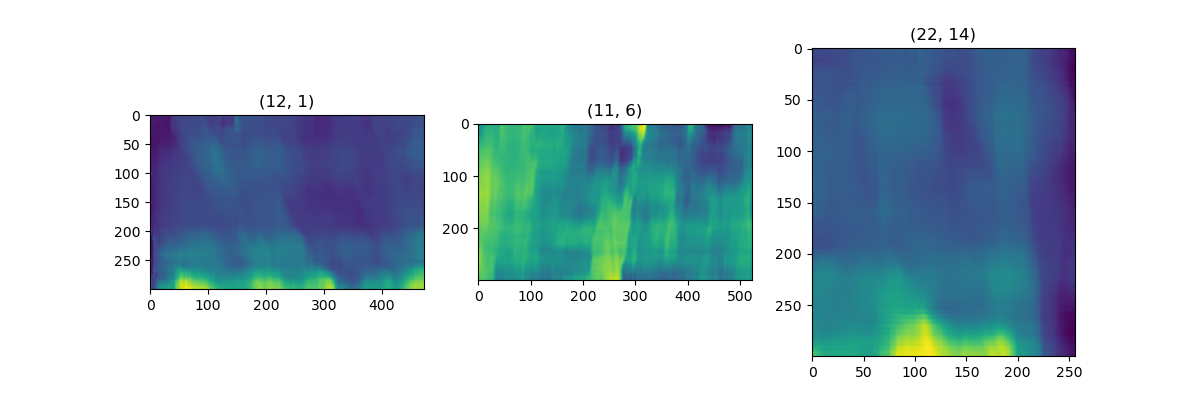

In [67]:
fig,axs = gridplot(len(kymos),ncols = 3)
for i,ax in enumerate(axs):
    ax.imshow(speeds[edges[i]])
    ax.set_title(str(edges[i]))

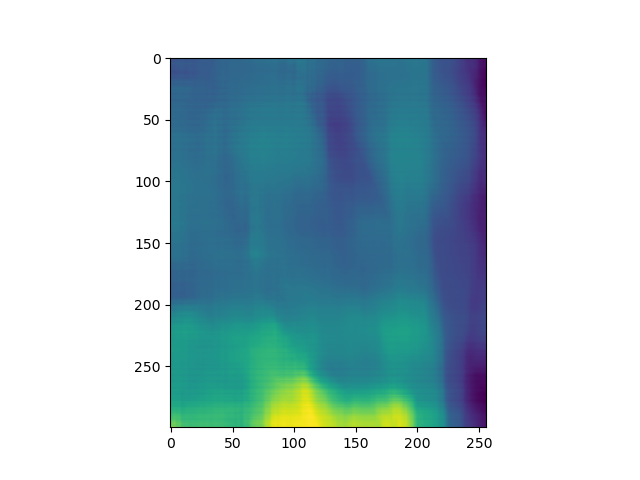

In [65]:
imgCoherency, imgOrientation = calcGST(kymos[edge], 50)
fix,ax = plt.subplots()
ax.imshow(imgOrientation)

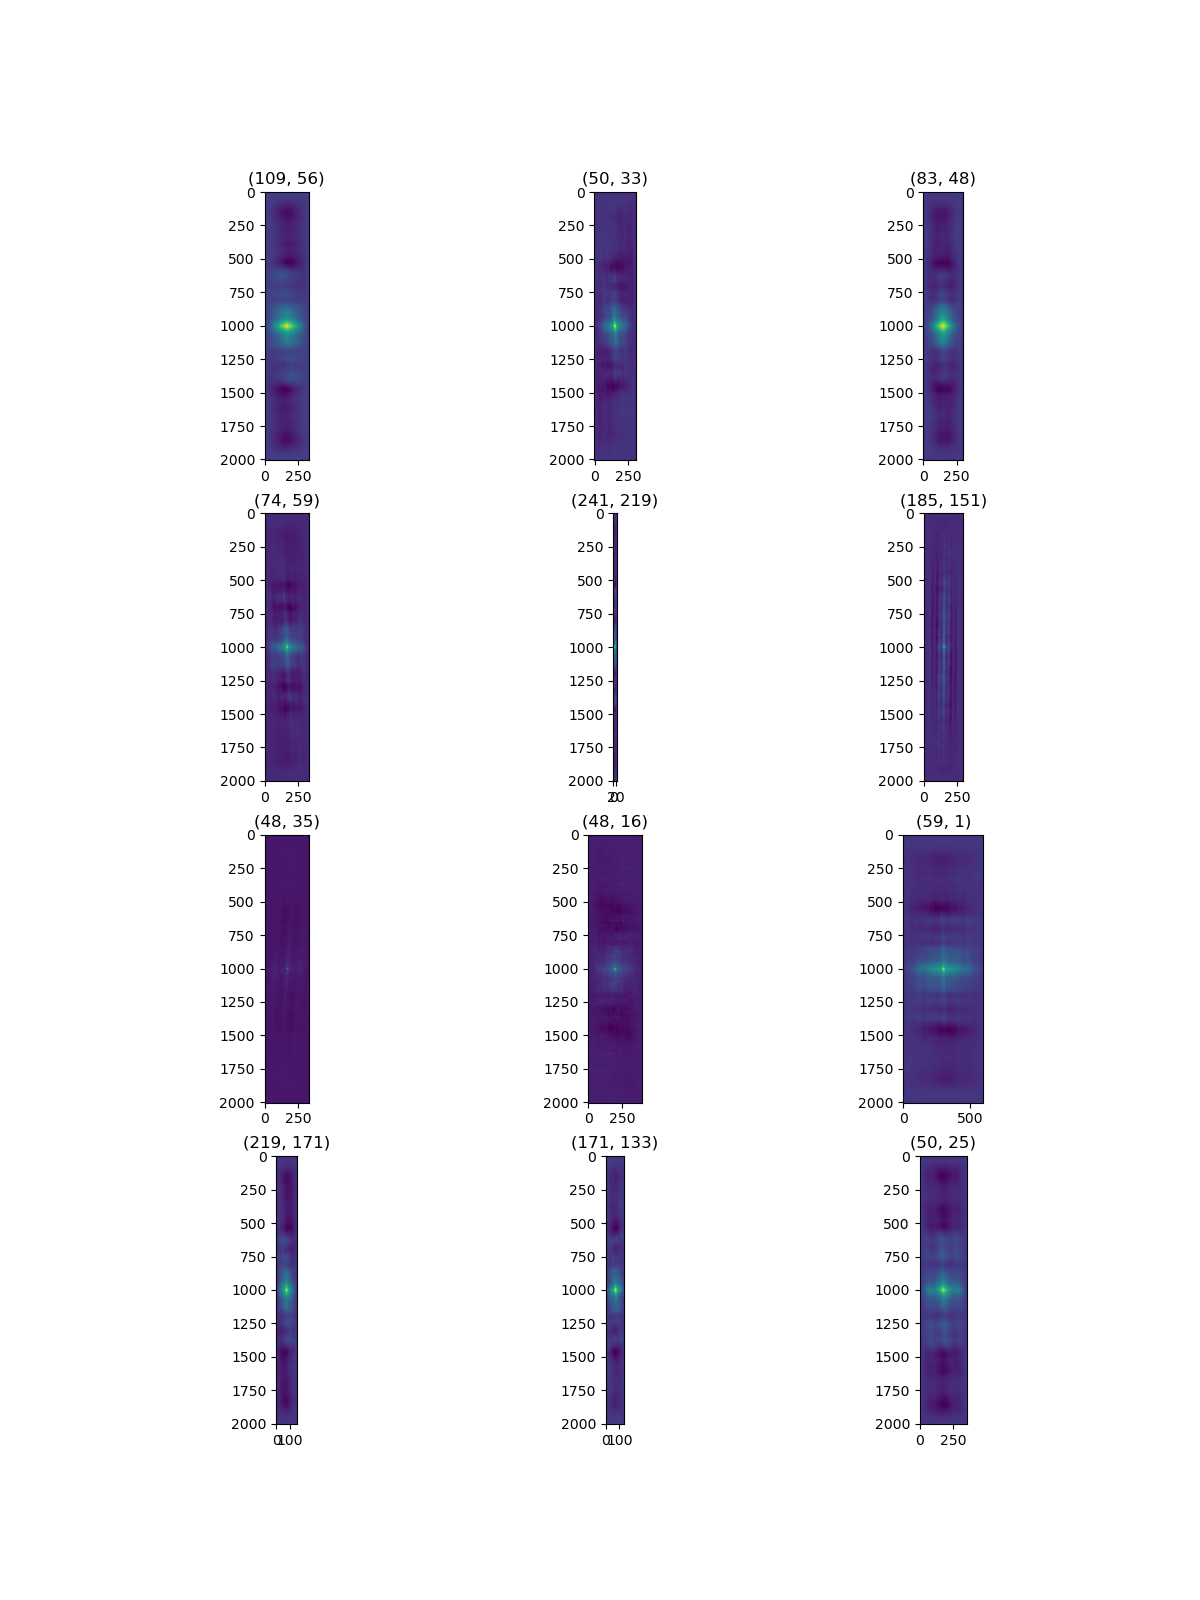

In [19]:
fig,axs = gridplot(len(kymos),ncols = 3)
for i,ax in enumerate(axs):
    ax.imshow(corrs[edges[i]])
    ax.set_title(str(edges[i]))

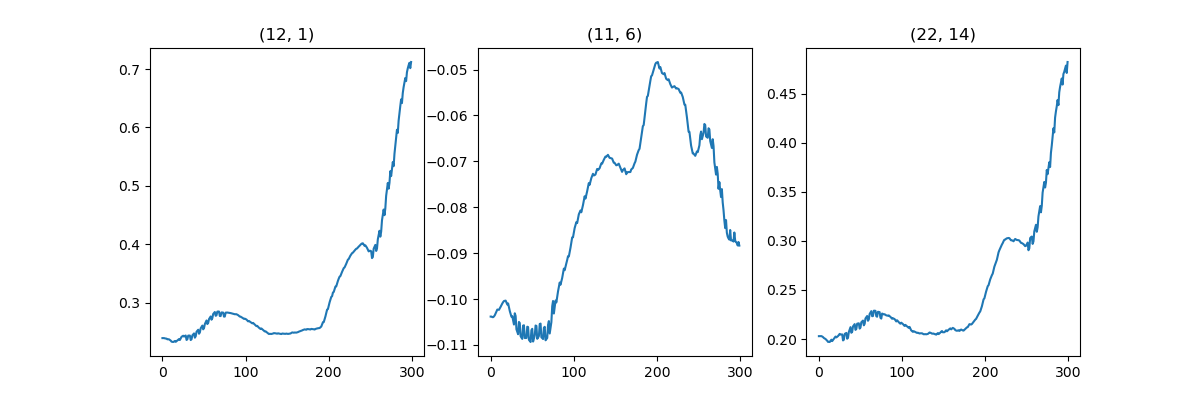

In [70]:
mean_speed = {edge:np.mean(speeds[edge],axis=1) for edge in edges}
fig,axs = gridplot(len(kymos),ncols = 3)
for i,ax in enumerate(axs):
    ax.plot(mean_speed[edges[i]])
    ax.set_title(str(edges[i]))
    # ax.set_ylim((0,-8.5))

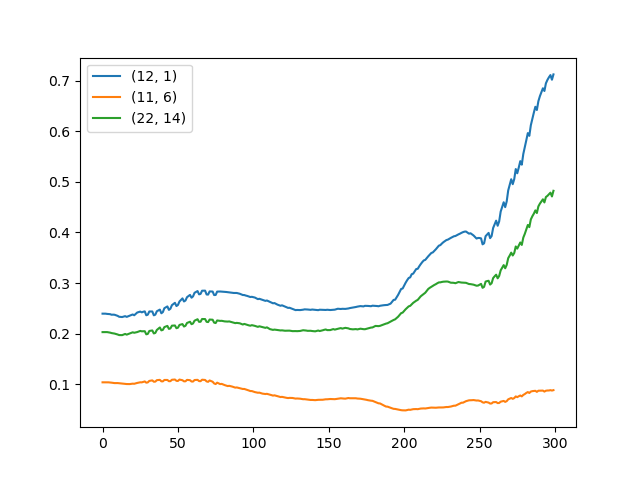

In [72]:
fig,ax = plt.subplots()
for edge in edges:
    ax.plot(np.abs(mean_speed[edge]),label=edge)
# ax.set_ylim(0,-10)
plt.legend()

In [50]:
cross_corrs={}
signal_compare = (mean_speed[(219,171)]-np.mean(mean_speed[(219,171)]))/(np.std(mean_speed[(219,171)]))
for edge in edges:
    signal_2 = (mean_speed[edge]-np.mean(mean_speed[edge]))/(np.std(mean_speed[edge]))

    cross_corrs[edge] = signal.correlate(signal_2,signal_compare)

In [48]:
cross_corrs[edge]

array([3313.1567], dtype=float32)

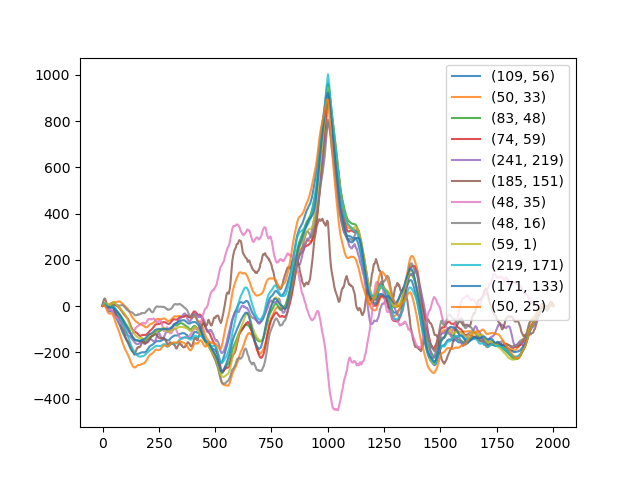

In [58]:
fig,ax = plt.subplots()
for edge in edges:
    time_corr = cross_corrs[edge]
    ts = np.linspace(0,length_time/2,len(time_corr))
    length_time= time_pixel_size*len(time_corr)
    ax.plot(time_corr,label=edge,alpha=0.8)


plt.legend()

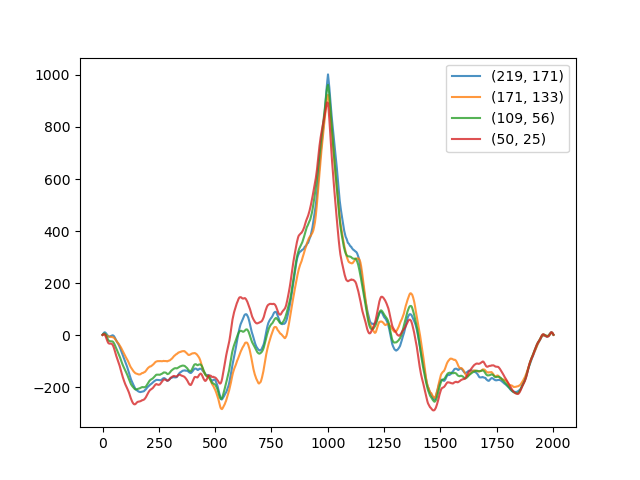

In [67]:
fig,ax = plt.subplots()
for edge in [(219,171),(171,133),(109,56),(50,25)]:
    time_corr = cross_corrs[edge]
    ts = np.linspace(0,length_time/2,len(time_corr))
    length_time= time_pixel_size*len(time_corr)
    ax.plot(time_corr,label=edge,alpha=0.8)


plt.legend()

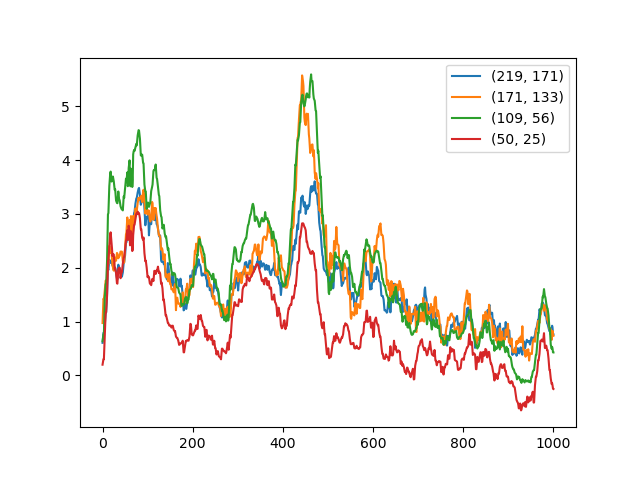

In [66]:
fig,ax = plt.subplots()
for edge in [(219,171),(171,133),(109,56),(50,25)]:
    ax.plot(mean_speed[edge],label=edge)

plt.legend()